In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , classification_report
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split , StratifiedKFold , RandomizedSearchCV
from tensorflow.keras.layers import Dense , InputLayer , Dropout , Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
import xgboost as xgb

# Reading & Exploring Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
features_train = pd.read_csv('/content/drive/My Drive/csvTrainImages 60k x 784.csv')
target_train = pd.read_csv("/content/drive/My Drive/csvTrainLabel 60k x 1.csv")
features_test = pd.read_csv("/content/drive/My Drive/csvTestImages 10k x 784.csv")
target_test = pd.read_csv("/content/drive/My Drive/csvTestLabel 10k x 1.csv")

Mounted at /content/drive


In [ ]:
features_train.info

<bound method DataFrame.info of        0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.486  0.487  \
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      0    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      0    0    0    0    0    0    0    0    0    0  ...      0      0   
...   ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
59994  0    0    0    0    0    0    0    0    0    0  ...      0      0   
59995  0    0    0    0    0    0    0  170  146   97  ...      0      0   
59996  0    0    0    0    0    0    0    0    0    0  ...      0      0   
59997  0    0    0    0    0    0    0    0    0    0  ...      0      0   
59998  0    0    0    0    0    0    0    0    0    0  ...      0      0   

       0.488  0.489  0.490  0.491  0.492  0.493  0.494  0.495  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
59994      0      0      0      0      0      0      0      0  
59995      0      0      0      0      0      0      0      0  
59996      0      0      0      0      0      0      0      0  
59997      0      0      0      0      0      0      0      0  
59998      0      0      0      0      0      0      0      0  

[59999 rows x 784 columns]>

In [ ]:
#features_train.isnull().sum()

In [ ]:
#features_test.isnull().sum()

detecting number of classes

In [ ]:
num_classes_train = target_train.nunique()
print(f"Number of classes: {num_classes_train}")

Number of classes: 0    10
dtype: int64


In [ ]:
num_classes_test = target_test.nunique()
print(f"Number of classes: {num_classes_test}")

Number of classes: 0    10
dtype: int64


# Preprocessing

### scaling the data,since the largest vlaue is 255 so dividing all values by 255

In [4]:
features_train = features_train / 255.0
features_test =  features_test / 255.0

In [ ]:
features_train.sample(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.486,0.487,0.488,0.489,0.490,0.491,0.492,0.493,0.494,0.495
51722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
features_test.sample(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.538,0.539,0.540,0.541,0.542,0.543,0.544,0.545,0.546,0.547
1279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## splitting data into train ,test and validation

In [ ]:
#x_train , x_val , y_train , y_val = train_test_split(x_train1 , y_train1 , test_size = 0.12 , random_state = 42 , stratify = y_train1)

In [ ]:
'''print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test1.shape)
print(y_test1.shape)'''

(52799, 784)
(52799, 1)
(7200, 784)
(7200, 1)
(9999, 784)
(9999, 1)


In [5]:
x_train = features_train.to_numpy()
y_train = target_train.to_numpy()
x_test = features_test.to_numpy()
y_test = target_test.to_numpy()

Class Distribution in Training Set:
Class 0: 5999 instances
Class 1: 6000 instances
Class 2: 6000 instances
Class 3: 6000 instances
Class 4: 6000 instances
Class 5: 6000 instances
Class 6: 6000 instances
Class 7: 6000 instances
Class 8: 6000 instances
Class 9: 6000 instances


<ipython-input-8-af6031e1c47e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Blues_d")


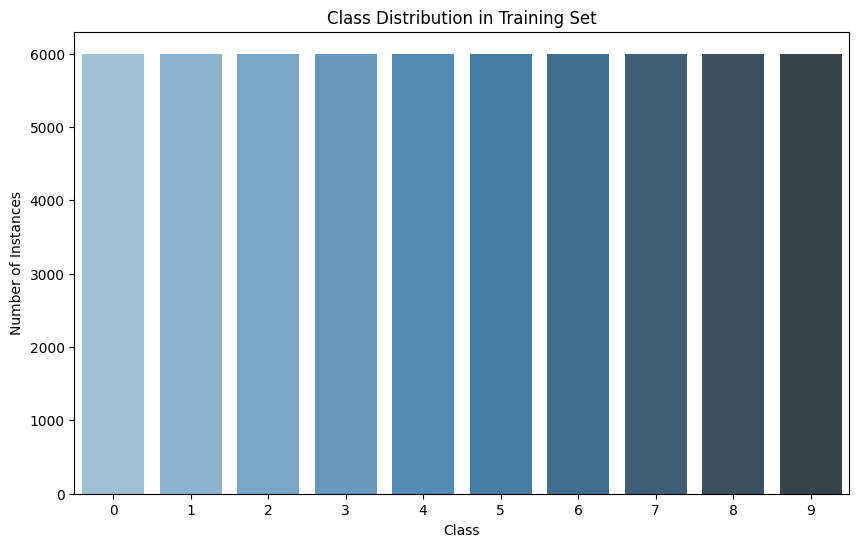

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution in Training Set:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} instances")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Blues_d")
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.show()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(59999, 784)
(59999, 1)
(9999, 784)
(9999, 1)


#### Apllying stratifiedkfold with k = 5

In [8]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(x_train, y_train):
    x_train_f, x_val = x_train[train_index], x_train[test_index]
    y_train_f, y_val = y_train[train_index], y_train[test_index]

In [ ]:
x_train_f.shape

(38400, 784)

# Modeling using XGboost with hyperparameter Tuning

In [ ]:
'''from scipy.stats import uniform, randint
xg_clf = xgb.XGBClassifier(objective='multi:softprob')
best_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

In [ ]:
''' random_search = RandomizedSearchCV(
    estimator=xg_clf,
    param_distributions=best_params,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    verbose=3,
    random_state=42)
    #n_jobs=-1)'''

In [ ]:
'''#Fit the random search model
random_search.fit(x_train, y_train)

# Print the best parameters and best accuracy
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)'''

'#Fit the random search model\nrandom_search.fit(x_train, y_train)\n\n# Print the best parameters and best accuracy\nprint("Best parameters found: ", random_search.best_params_)\nprint("Best accuracy found: ", random_search.best_score_)'

 by using randomizedsearch for hyperparameters tuning we get these reslts:
* [CV 1/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=140, reg_alpha=0.1, reg_lambda=3, subsample=0.9;, score=0.984 total time= 8.8min
* [CV 2/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=140, reg_alpha=0.1, reg_lambda=3, subsample=0.9;, score=0.985 total time= 8.8min
* [CV 3/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=140, reg_alpha=0.1, reg_lambda=3, subsample=0.9;, score=0.985 total time= 8.9min
* [CV 4/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=140, reg_alpha=0.1, reg_lambda=3, subsample=0.9;, score=0.984 total time= 8.7min
* [CV 5/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, n_estimators=140, reg_alpha=0.1, reg_lambda=3, subsample=0.9;, score=0.986 total time= 8.8min

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softprob' , colsample_bytree=0.7541666010159664, gamma=0.007983126110107097, learning_rate=0.0792681476866447, max_depth=6, n_estimators=466, reg_alpha=0.6832635188254582, reg_lambda=0.6099966577826209, subsample=0.9332779646944658,n_jobs=-1)
xgb_clf.fit(x_train_f , y_train_f)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7541666010159664, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.007983126110107097,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0792681476866447,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=466, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Predict using the test set
y_pred = xgb_clf.predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9868736326700698


In [ ]:
y_pred[10]

1

In [ ]:
y_val[10]

array([1])

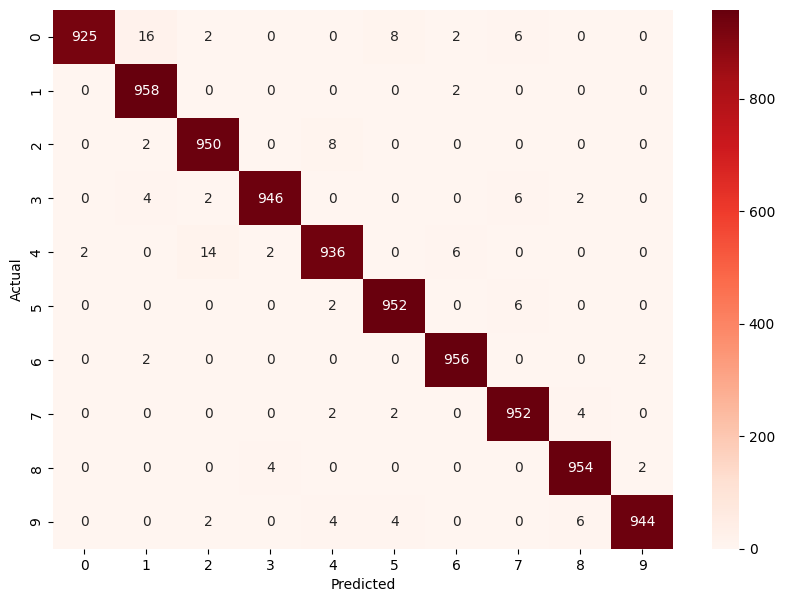

In [ ]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
cr = classification_report(y_val, y_pred)
print(cr)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       959
           1       0.98      1.00      0.99       960
           2       0.98      0.99      0.98       960
           3       0.99      0.99      0.99       960
           4       0.98      0.97      0.98       960
           5       0.99      0.99      0.99       960
           6       0.99      1.00      0.99       960
           7       0.98      0.99      0.99       960
           8       0.99      0.99      0.99       960
           9       1.00      0.98      0.99       960

    accuracy                           0.99      9599
   macro avg       0.99      0.99      0.99      9599
weighted avg       0.99      0.99      0.99      9599



In [ ]:
import joblib
joblib.dump(xgb_clf,'/content/drive/My Drive/xgboost_model.joblib')

['/content/drive/My Drive/xgboost_model.joblib']

# Modeling with ANN

#### Applying Hyperparameters tuning using randomizedsearch

In [ ]:
'''def create_model(optimizer='adam', activation='relu', dropout_rate=0.0, neurons=32, num_classes=10):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model'''

In [ ]:
'''param_dist_ann = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'neurons': [16, 32, 64, 128],
    'batch_size': [10, 20, 30],
    'epochs': [10, 50, 100]
}'''

In [ ]:
#random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist_ann, n_iter=10, cv=3, verbose=2)

In [ ]:
'''def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))

    # Add hidden layers with random number of units
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))

    model.add(Dense(1, activation='linear'))'''

In [ ]:
'''y_train_ohe = to_categorical(y_train_f)
y_val_ohe  = to_categorical(y_val)
print(y_train_ohe.shape, y_val_ohe.shape)'''

'y_train_ohe = to_categorical(y_train_f)\ny_val_ohe  = to_categorical(y_val)\nprint(y_train_ohe.shape, y_val_ohe.shape)'

In [9]:
model = Sequential(
    [
        InputLayer(input_shape=(784,)),
        Dense(35, activation='relu', name='layer1', kernel_regularizer=regularizers.l2(0.01)),
        Dense(20, activation='relu', name='layer2', kernel_regularizer=regularizers.l2(0.01)),
        Dense(10, activation='softmax', name='layer3')
    ]
)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 35)                  │          27,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 20)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,405 (110.96 KB)

 Trainable params: 28,405 (110.96 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
   optimizer = 'Adam',
   loss = 'sparse_categorical_crossentropy',
   metrics = ['accuracy']
)
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [13]:
history = model.fit(x_train_f, y_train_f, epochs=80, batch_size=32,validation_data=(x_val, y_val) , callbacks=[model_checkpoint_callback])


Epoch 1/80
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 1.0100
Epoch 1: val_accuracy improved from -inf to 0.95341, saving model to best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8572 - loss: 1.0057 - val_accuracy: 0.9534 - val_loss: 0.4338
Epoch 2/80
1482/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9607 - loss: 0.3820
Epoch 2: val_accuracy improved from 0.95341 to 0.95625, saving model to best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9607 - loss: 0.3818 - val_accuracy: 0.9562 - val_loss: 0.3640
Epoch 3/80
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.3261
Epoch 3: val_accuracy improved from 0.95625 to 0.96033, saving model to best.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9641 - loss: 0.3260 - val_accuracy: 0.9603 - val_loss: 0.3243
Epoch 4/80
1471/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.2935
Epoch 4: val_accuracy did not improve from 0.

In [14]:
model.evaluate(x_val, y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9664 - loss: 0.1885


[0.1681620180606842, 0.9699975252151489]

In [15]:
model.evaluate(x_train_f, y_train_f)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9818 - loss: 0.1337


[0.13585707545280457, 0.981166660785675]

In [16]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.1581


[0.16959913074970245, 0.9676967859268188]

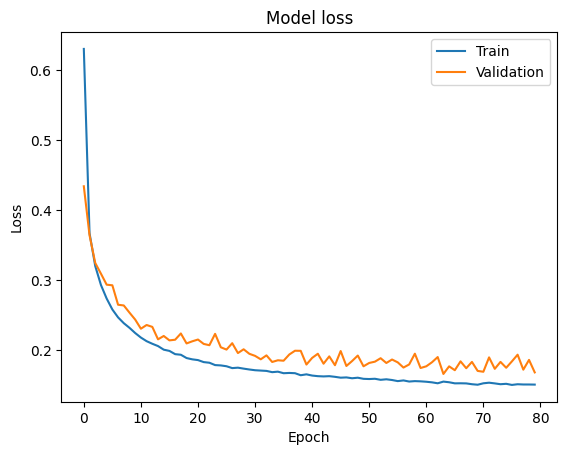

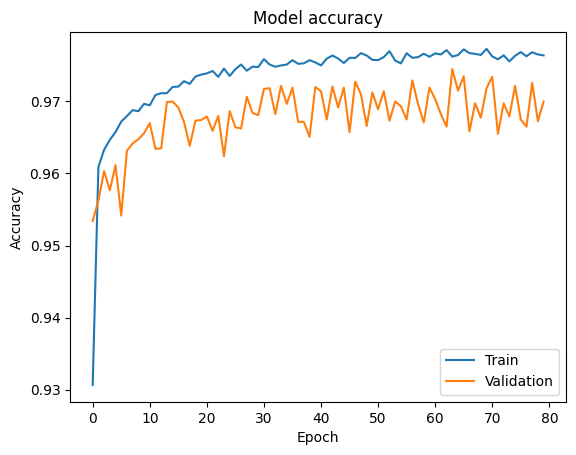

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [18]:
y_pred_ann = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_ann, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [19]:
y_pred_ann

array([[7.6924888e-03, 9.8889071e-01, 2.9054981e-05, ..., 5.4657139e-04,
        1.3010851e-04, 1.9523872e-04],
       [2.0550046e-04, 2.3012953e-03, 9.4472849e-01, ..., 5.5127097e-03,
        4.9625416e-03, 1.0774254e-02],
       [7.9904799e-05, 7.9747788e-06, 3.4150850e-02, ..., 1.8728581e-04,
        5.1809082e-05, 1.7373833e-03],
       ...,
       [1.8747760e-05, 1.6889284e-07, 1.9181289e-06, ..., 9.9965322e-01,
        2.1248165e-11, 2.4366939e-08],
       [9.2172064e-05, 2.0458381e-07, 2.4368457e-04, ..., 2.3955559e-08,
        9.9186069e-01, 8.2029301e-06],
       [2.7662626e-04, 4.4997023e-06, 5.3113861e-05, ..., 4.3669340e-04,
        5.6492599e-06, 9.9603039e-01]], dtype=float32)

In [20]:
y_pred_classes

array([1, 2, 3, ..., 7, 8, 9])

In [21]:
y_test

array([[1],
       [2],
       [3],
       ...,
       [7],
       [8],
       [9]])

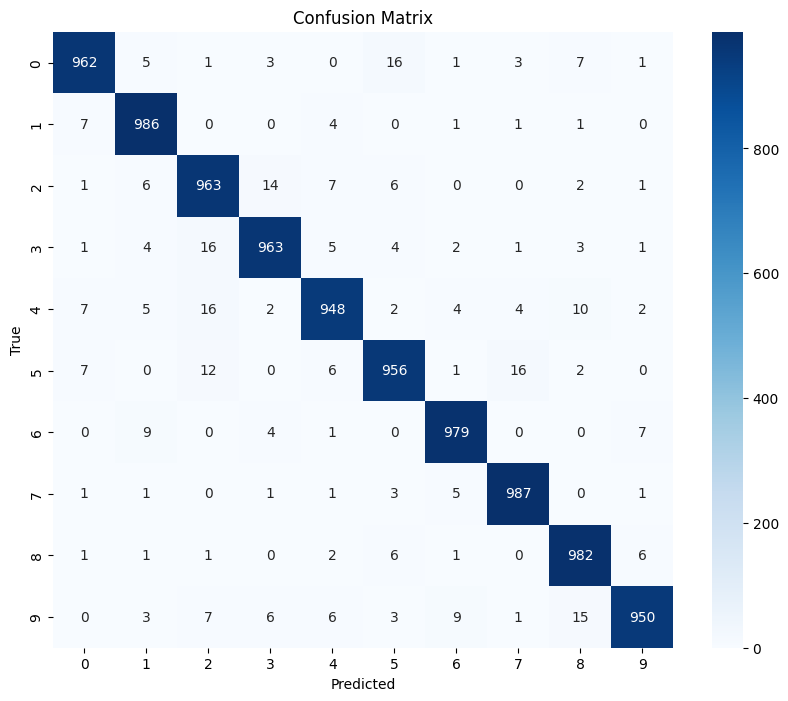

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
class_report = classification_report(y_test, y_pred_classes)

# Print the classification report
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       999
           1       0.97      0.99      0.98      1000
           2       0.95      0.96      0.96      1000
           3       0.97      0.96      0.97      1000
           4       0.97      0.95      0.96      1000
           5       0.96      0.96      0.96      1000
           6       0.98      0.98      0.98      1000
           7       0.97      0.99      0.98      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



In [25]:
model.save('/content/drive/My Drive/ar_digits_upd.h5')

In [26]:
from keras.models import load_model
model1 = load_model('/content/drive/My Drive/ar_digits_upd.h5')

In [27]:
model1.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.1581


[0.16959913074970245, 0.9676967859268188]

In [28]:
print(model1.layers[0].get_weights())


[array([[-2.1525579e-34,  9.5418349e-35, -5.0951509e-34, ...,
         3.6467285e-34,  5.0921405e-34, -4.5952793e-34],
       [-2.7574306e-34,  2.9755750e-34,  3.2496291e-06, ...,
        -7.7962206e-35,  1.7822551e-34, -5.3512984e-34],
       [-5.5026277e-34,  2.8661335e-34, -2.0122305e-34, ...,
        -4.0702846e-35,  3.4109627e-34, -5.6280456e-34],
       ...,
       [ 2.9816814e-34, -4.9883489e-34, -8.2608371e-35, ...,
         1.6896922e-34, -2.4867955e-34, -2.8379115e-34],
       [ 3.6190964e-34, -4.7284669e-34, -5.4125059e-34, ...,
        -3.2084035e-34,  4.0352999e-35, -3.0233921e-34],
       [ 4.2379400e-34,  2.7240750e-35,  2.9963620e-34, ...,
        -5.1879300e-34,  2.2299546e-34,  2.6972489e-34]], dtype=float32), array([-2.1623351e-01, -8.8512581e-03, -2.6367949e-03, -2.4671952e-04,
       -3.1120013e-03,  2.6712382e-01,  6.6166162e-01, -8.4878979e-03,
       -1.5983797e-03, -1.0684157e-01,  7.4604493e-01, -2.3160258e-03,
        2.6799285e-01, -3.0876624e-03, -7.8588054

In [30]:
test_predictions_colab = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [31]:
test_predictions_colab

array([[7.6924888e-03, 9.8889071e-01, 2.9054981e-05, ..., 5.4657139e-04,
        1.3010851e-04, 1.9523872e-04],
       [2.0550046e-04, 2.3012953e-03, 9.4472849e-01, ..., 5.5127097e-03,
        4.9625416e-03, 1.0774254e-02],
       [7.9904799e-05, 7.9747788e-06, 3.4150850e-02, ..., 1.8728581e-04,
        5.1809082e-05, 1.7373833e-03],
       ...,
       [1.8747760e-05, 1.6889284e-07, 1.9181289e-06, ..., 9.9965322e-01,
        2.1248165e-11, 2.4366939e-08],
       [9.2172064e-05, 2.0458381e-07, 2.4368457e-04, ..., 2.3955559e-08,
        9.9186069e-01, 8.2029301e-06],
       [2.7662626e-04, 4.4997023e-06, 5.3113861e-05, ..., 4.3669340e-04,
        5.6492599e-06, 9.9603039e-01]], dtype=float32)

In [32]:
print(model.layers[-1].activation)

<function softmax at 0x7a10a9ac5c60>


In [33]:
import tensorflow as tf
print(tf.__version__)  # Ensure this matches in both environments

2.17.0


In [34]:
preds = test_predictions_colab.argmax(axis=1)
preds

array([1, 2, 3, ..., 7, 8, 9])